## Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4-tf


## Enable Eager Mode

In [2]:
tf.enable_eager_execution()

## Hyper Parameters

In [3]:
learning_rate = 0.001
training_epochs = 30
batch_size = 100

tf.set_random_seed(777)

## MNIST/Fashion MNIST Data

In [4]:
## MNIST Dataset #########################################################
#mnist = keras.datasets.mnist
#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Cifar10 Dataset #########################################################
cifar = keras.datasets.cifar10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
############################################################################

## Datasets

In [5]:
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()    
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
#train_images = np.expand_dims(train_images, axis=-1)
#test_images = np.expand_dims(test_images, axis=-1)
print(train_images.shape)
print(test_images.shape)
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


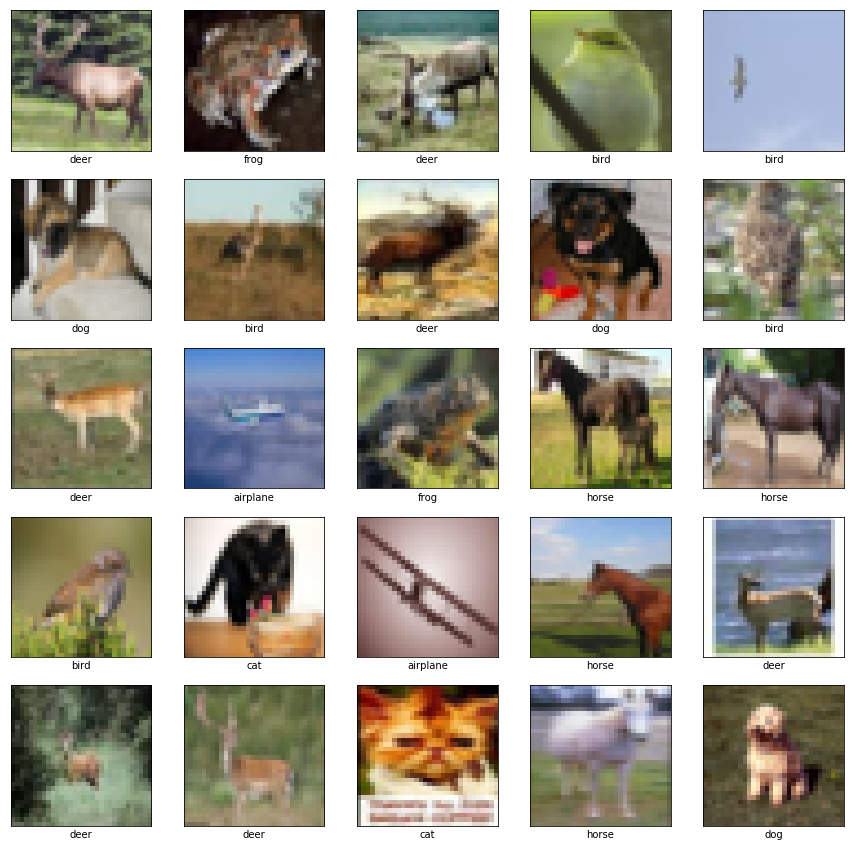

In [6]:
plt.figure(figsize=(15,15))
for i in range(25):
    img_idx = np.random.randint(0, 49999)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_names[np.argmax(train_labels[img_idx])])

## Model Function

In [7]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME', 
                                  input_shape=(32, 32, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10))
    return model

In [8]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxP

## Loss Function

In [9]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=logits, labels=labels))    
    return loss   

## Calculating Gradient

In [10]:
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

## Caculating Model's Accuracy

In [11]:
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

## Optimizer

In [12]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Training

In [13]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        grads = grad(model, images, labels)                
        optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 1.56433558 train accuracy =  0.4549 test accuracy =  0.5237
Epoch: 2 loss = 1.15724099 train accuracy =  0.6084 test accuracy =  0.6064
Epoch: 3 loss = 0.97563690 train accuracy =  0.6785 test accuracy =  0.6708
Epoch: 4 loss = 0.86139810 train accuracy =  0.7236 test accuracy =  0.6946
Epoch: 5 loss = 0.77725971 train accuracy =  0.7585 test accuracy =  0.6958
Epoch: 6 loss = 0.69850224 train accuracy =  0.7847 test accuracy =  0.7039
Epoch: 7 loss = 0.64069861 train accuracy =  0.8071 test accuracy =  0.7096
Epoch: 8 loss = 0.58967143 train accuracy =  0.8251 test accuracy =  0.7093
Epoch: 9 loss = 0.54607505 train accuracy =  0.8436 test accuracy =  0.7008
Epoch: 10 loss = 0.49595019 train accuracy =  0.8615 test accuracy =  0.7187
Epoch: 11 loss = 0.45963427 train accuracy =  0.8775 test accuracy =  0.7268
Epoch: 12 loss = 0.43372455 train accuracy =  0.8889 test accuracy =  0.7225
Epoch: 13 loss = 0.40165478 train accuracy =  0.